In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import itertools
import cv2
import numpy as np
from matplotlib import pyplot as plt
import xml.etree.ElementTree as ET

In [ ]:
#####################################    SPLIT THE DATASET    ###################################################

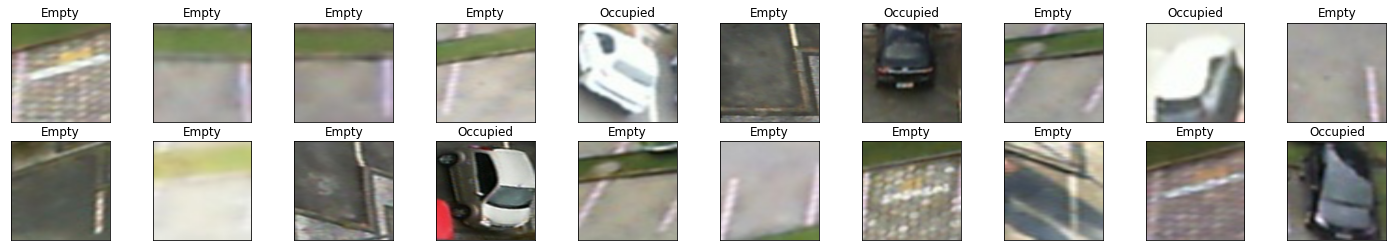

In [14]:
# location on Google Drive
test_p = './test'
batch_size = 32
num_workers = 1
classes = ["Empty", "Occupied"]

transform = transforms.Compose([transforms.Resize((224,224)), 
                                transforms.ToTensor()])
test_s = torchvision.datasets.ImageFolder(test_p, transform=transform)
test_loader = torch.utils.data.DataLoader(test_s, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

# Verification
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.numpy()
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

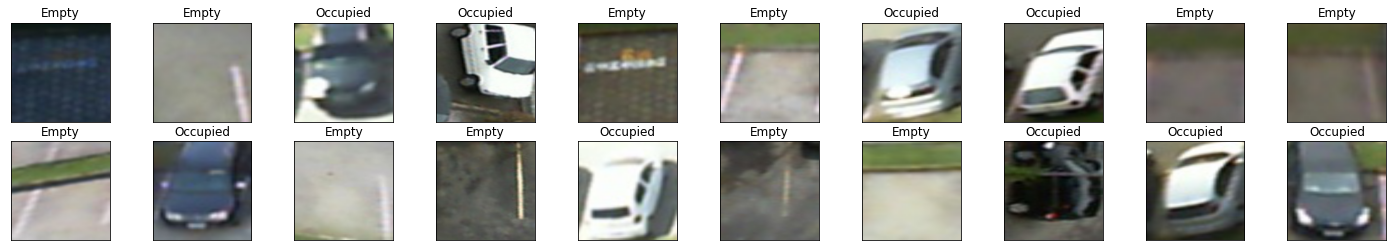

In [15]:
data = './train_validation'
batch_size = 32
num_workers = 1
classes = ["Empty", "Occupied"]

transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
data = torchvision.datasets.ImageFolder(data, transform=transform)
# Split into train and validation
np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
relevant_indices = [i for i in range(len(data))]
np.random.shuffle(relevant_indices)
split = int(len(data) * 0.66) #split at 66%
# split into training and validation indices
relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]  
train_sampler = SubsetRandomSampler(relevant_train_indices)
train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,
                                           num_workers=1, sampler=train_sampler)
val_sampler = SubsetRandomSampler(relevant_val_indices)
val_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,
                                          num_workers=1, sampler=val_sampler)

# Verification Step
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [29]:
print('Length of training dataset: ', len(train_loader.dataset))
print('Length of validation dataset: ', len(val_loader.dataset))
print('Length of testing dataset: ', len(test_loader.dataset))

Length of training dataset:  520845
Length of validation dataset:  520845
Length of testing dataset:  175006


In [ ]:
#####################################    TRAIN CLASSIFIER    ###################################################

In [17]:
class car_net(nn.Module):
  def __init__(self):
    super(car_net, self).__init__()
    self.name = 'car'
    self.conv1 = nn.Conv2d(3, 5, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(5, 10, 5)
    self.fc1 = nn.Linear(10 * 53 * 53, 32)
    self.fc2 = nn.Linear(32, 2)
    
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 10 * 53 * 53)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    x = x.squeeze(1) # Flatten to [batch_size]
    return x

In [37]:
def get_accuracy(model, data_loader, n):
    correct, total, count = 0,0,0
    for imgs, labels in data_loader:
        if count >= n:
            break
        output = model(imgs)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
        count += 1
    return correct / total

def training(model, train_loader, val_loader, num_epochs=5, learn_rate = 0.001):

    torch.manual_seed(1000)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learn_rate)
    train_acc, val_acc = [], []

    # training
    print ("Training Started...")
    for epoch in range(num_epochs):
        for imgs, labels in itertools.islice(train_loader, 250):
            out = model(imgs)            
            loss = criterion(out, labels) 
            loss.backward()               
            optimizer.step()            
            optimizer.zero_grad()        
            # track accuracy
            pred = out.max(1, keepdim=True)[1]
            mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
            Mini_batch_total = imgs.shape[0]
        train_acc.append((mini_batch_correct / Mini_batch_total))
        val_acc.append(get_accuracy(model, val_loader, 250))

        print(("Epoch {}: Train Accuracy: {}").format(
                  epoch,
                  train_acc[epoch]))
        print(("Epoch {}: Validation Accuracy: {}").format(
                  epoch,
                  val_acc[epoch]))
        
    return train_acc, val_acc

In [19]:
c_net = car_net()
train_a, val_a = training(c_net, train_loader, val_loader)

Training Started...
Epoch 0: Train Accuracy: 0.9375
Epoch 0: Validation Accuracy: 0.965625
Epoch 1: Train Accuracy: 1.0
Epoch 1: Validation Accuracy: 0.963875
Epoch 2: Train Accuracy: 1.0
Epoch 2: Validation Accuracy: 0.973625
Epoch 3: Train Accuracy: 1.0
Epoch 3: Validation Accuracy: 0.991
Epoch 4: Train Accuracy: 1.0
Epoch 4: Validation Accuracy: 0.985625


In [26]:
# saves the model
# to load the model: the_model = torch.load(PATH)
torch.save(c_net, '/Users/gracegan/Desktop/aps360_project/model')

In [28]:
test = get_accuracy(c_net, test_loader, 250)
print('test accuracy is: ', test)

test accuracy is:  0.983125


In [ ]:
###################################    USING CLASSIFIER   ########################################################

In [21]:
tree = ET.parse("/Users/gracegan/Desktop/aps360_project/PR5C.xml")
root = tree.getroot()
img = cv2.imread("/Users/gracegan/Desktop/aps360_project/PR5C.jpg")

In [22]:
def crop_rect(img, rect):
    # get the parameter of the small rectangle
    center, size, angle = rect[0], rect[1], rect[2]
    center, size = tuple(map(int, center)), tuple(map(int, size))

    # get row and col num in img
    height, width = img.shape[0], img.shape[1]
    # calculate the rotation matrix
    M = cv2.getRotationMatrix2D(center, angle, 1)
    # rotate the original image
    img_rot = cv2.warpAffine(img, M, (width, height))
    

    # now rotated rectangle becomes vertical, and we crop it
    img_crop = cv2.getRectSubPix(img_rot, size, center)

    return img_crop

In [110]:
def evaluate_parking_spot(img):
    # [batch, 3, img_d, img_d]
    c_net.eval()
    img = torch.Tensor(img)
    img = img.unsqueeze(0)
    img = img.permute(0,3,1,2)
    out = torch.sigmoid(c_net(img))
    return out.tolist()

In [111]:
empty, occupied = 0,0
for i in range(len(root)):
    if (root[i][0][0].get('x')!=None):
        c=(int(root[i][0][0].get('x')),int(root[i][0][0].get('y')))
        size=(int(root[i][0][1].get('w')),int(root[i][0][1].get('h')))
        r=int(root[i][0][2].get('d'))
        rect =  (c,size,r)
        img_crop = crop_rect(img, rect)
        img_crop = cv2.resize(img_crop, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
        result = evaluate_parking_spot(img_crop)[0]
        if result[0]>result[1]:
            occupied += 1
        else:
            empty += 1
print('Number of empty parking spots: ', empty)
print('Number of occupied parking spots: ', occupied)
    

Number of empty parking spots:  5
Number of occupied parking spots:  35


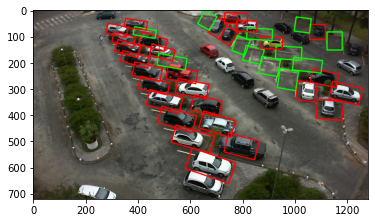

In [24]:
# verification
for i in range(len(root)):
  if (root[i][0][0].get('x')!=None):
    c=(int(root[i][0][0].get('x')),int(root[i][0][0].get('y')))
    size=(int(root[i][0][1].get('w')),int(root[i][0][1].get('h')))
    r=int(root[i][0][2].get('d'))
    rect =  (c,size,r)
    box = cv2.boxPoints(rect) 
    box = np.int0(box)
    if root[i].get('occupied')=='1':
      img=cv2.drawContours(img,[box],0,(0,0,255),3)
    else:
      img=cv2.drawContours(img,[box],0,(0,255,0),3)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [ ]:
# Ignore the below code

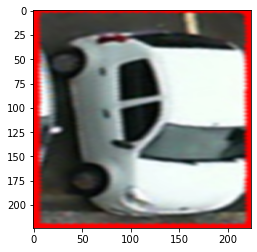

In [80]:
centerx=int(root[0][0][0].get('x'))
root[0][0][0].get('x')
centery=int(root[0][0][0].get('y'))
root[0][0][0].get('y')
sizew=int(root[0][0][1].get('w'))
root[0][0][1].get('w')
sizeh=int(root[0][0][1].get('h'))
root[0][0][1].get('h')
c=(centerx,centery)
size=(sizew,sizeh)
r=int(root[0][0][2].get('d'))
rect =  (c,size,r)
img_crop = crop_rect(img, rect)
img_crop = cv2.resize(img_crop, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
plt.imshow(cv2.cvtColor(img_crop, cv2.COLOR_BGR2RGB))